# `SiFT`ing spatial signal from liver scRNA-seq data 

This notebook uses `novoSpaRc` [[1]](https://www.nature.com/articles/s41586-019-1773-3) to get a spatial embedding of the single-cell gene expression by using liver gene expression dataset from ''Space-time logic of liver gene expression'' [[2]](https://www.nature.com/articles/s42255-020-00323-1). 

Then performs filtering using `SiFT` to enhance temporal signal using:
1. _knn kernel_ based on spatial genes 
2. `novoSpaRc` spatial mapping.

[[1] Nitzan, M., Karaiskos, N., Friedman, N., & Rajewsky, N. (2019). Gene expression cartography. Nature, 576(7785), 132-137.](https://www.nature.com/articles/s41586-019-1773-3)

[[2] Droin, C., Kholtei, J. E., Bahar Halpern, K., Hurni, C., Rozenberg, M., Muvkadi, S., ... & Naef, F. (2021). Space-time logic of liver gene expression at sub-lobular scale. Nature metabolism, 3(1), 43-58.](https://www.nature.com/articles/s42255-020-00323-1)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pickle as pkl

import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import anndata
import pandas as pd
from pandas.api.types import CategoricalDtype
from scipy import ndimage

from matplotlib.pyplot import gcf


from IPython.utils import io
from scipy.sparse.csgraph import dijkstra

import sift

In [3]:
from mapping import MappingProblem, get_mapping

In [4]:
sys.path.append("../../")
from paths import DATA_DIR, FIG_DIR

In [57]:
DATA_DIR = str(DATA_DIR) + "/spatiotemporal_liver/"
OUTPUT_DIR = str(DATA_DIR) + "/spatiotemporal_liver/output/"
FIG_DIR = str(FIG_DIR) + "/spatiotemporal_liver/"

## Set parameters

In [6]:
import seaborn as sns
fontsize = 20
size = 4
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.transparent"] = True
plt.rcParams["figure.figsize"] = (size, size)

plt.rcParams["axes.titlesize"] = 15
plt.rcParams["axes.titleweight"] = 500
plt.rcParams["axes.titlepad"] = 8.0
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["axes.labelweight"] = 500
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.labelpad"] = 6.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


plt.rcParams["font.size"] = fontsize
plt.rcParams["font.sans-serif"] = ["Helvetica", "Computer Modern Sans Serif", "DejaVU Sans"]
plt.rcParams["font.weight"] = 500

plt.rcParams["xtick.labelsize"] = fontsize-4
plt.rcParams["xtick.minor.size"] = 1.375
plt.rcParams["xtick.major.size"] = 2.75
plt.rcParams["xtick.major.pad"] = 2
plt.rcParams["xtick.minor.pad"] = 2

plt.rcParams["ytick.labelsize"] = fontsize-4
plt.rcParams["ytick.minor.size"] = 1.375
plt.rcParams["ytick.major.size"] = 2.75
plt.rcParams["ytick.major.pad"] = 2
plt.rcParams["ytick.minor.pad"] = 2

plt.rcParams["legend.fontsize"] = fontsize
plt.rcParams["legend.handlelength"] = 1.4
plt.rcParams["legend.numpoints"] = 1
plt.rcParams["legend.scatterpoints"] = 1
plt.rcParams["legend.frameon"] = False

plt.rcParams["lines.linewidth"] = 1.7

sns.set(rc={"figure.dpi":200, "savefig.dpi":300})
plt.style.use("seaborn-whitegrid")
sns.set_style("whitegrid", {"xtick.direction": "out", "xtick.major.size": 3.0, "xtick.minor.size": 3.0,
                            "ytick.color": ".15", "ytick.direction": "out", "ytick.major.size": 3.0, 
                            "ytick.minor.size": 3.0, "font": ["DejaVu Sans"], "font.scale": 1, 
                            "legend.frameon":"True"})

DPI = 300
size=4

In [7]:
batch_key="rep"

In [8]:
l_temporal = ["arntl", "clock", "npas2", "nr1d1", "nr1d2", "per1", "per2", "cry1", "cry2", "dbp", "tef", "hlf", 
               "elovl3", "rora", "rorc"]
l_spatial= ["glul", "ass1","asl","cyp2f2","cyp1a2","pck1","cyp2e1", "cdh2","cdh1","cyp7a1","acly", "alb", "oat", 
             "aldob", "cps1"]

## Utility function

In [9]:
def train_scvi(adata ,layer=None, batch_key=None, continuous_covariate_keys=None):
    if layer is None:
        adata.layers["counts"] = adata.X.copy()
        layer = "counts"
    
    scvi.data.setup_anndata(adata, 
                            layer=layer,
                            batch_key=batch_key,
                            continuous_covariate_keys=continuous_covariate_keys)
    
    model = scvi.model.SCVI(adata,  
                            n_hidden=128, 
                            n_layers=2,
                            gene_likelihood='nb',
                            dispersion='gene-batch'
                            )

    # MODEL TRAINING
    model.train(check_val_every_n_epoch =1, 
                    use_gpu=True,
                    plan_kwargs={'lr':1e-3})

    latent = model.get_latent_representation()
    adata.obsm['X_scvi'] = latent

    sc.pp.neighbors(adata, use_rep='X_scvi')
    sc.tl.umap(adata, min_dist=0.3)
    return

def transform_data(x):
    return np.log2(x+10**-4)-np.log2(11*10**-5)

In [10]:
def sanitize_adata(adata):
    del adata.obsm["X_umap"]
    del adata.obsm["X_pca"]
    del adata.varm["PCs"]
    del adata.obsp["connectivities"]
    del adata.obsp["distances"]
    del adata.uns["_scvi"]
    del adata.uns["neighbors"]
    del adata.uns["umap"]
    del adata.uns["pca"]

In [11]:
def process_adata(adata, use_rep="X_pca", pseudocount=False):
    if pseudocount:
        adata.layers["X_sift"] =  adata.X.copy() - adata.X.min(0)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata, use_rep=use_rep)
    sc.tl.umap(adata)

In [12]:
def plot_multiheatmap(adata, markers, title=None, save_fig=False, layer=None):
    color_palettes = ["hls", "colorblind",]
    labels = ["timepoint", "layer",]
    
    genedf = sc.get.obs_df(
        adata,
        keys=["ZT", "layer", *markers],
        layer=layer,
    )
    
    ZT_order = CategoricalDtype(["0", "6", "12", "18"], 
                              ordered=True
                            )
    genedf["timepoint"] = genedf["ZT"].astype(ZT_order)
    genedf.sort_values("timepoint")
    grouped = genedf.groupby(["timepoint", "layer",])
    mean, var = grouped.mean(), grouped.var()
    mean = mean.dropna(how='all')
    

    colors = {}
    colors_joint = None
    for i, label in enumerate(labels):
        labels_cur = labels.copy()
        labels_cur.remove(label)
        label_arr = mean.index.droplevel(labels_cur)

        label_pal = sns.color_palette(color_palettes[i], label_arr.unique().size)
        label_lut = dict(zip(map(str, label_arr.unique()), label_pal))
        colors[label] = pd.Series(label_arr.astype(str), name=label).map(label_lut)

        if colors_joint is None:
            colors_joint = pd.DataFrame(colors[label])
        else:
            colors_joint = colors_joint.join(pd.DataFrame(colors[label]))


    ncols = [2, 2]
    bbox_to_anchors = [(0.4, 0.95), (0.75, 0.95)]


    g = sns.clustermap(mean.values.T,
                       row_cluster=False, col_cluster=False,
                       col_colors = colors_joint.to_numpy().T,
                       linewidths=0,
                       xticklabels=[], 
                       yticklabels=mean.columns,
                       figsize=(12,6),
                      )


    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90) 

    i=0
    labels_cur = [labels[-1]]
    label = labels[0]
    label_arr = mean.index.droplevel(labels_cur)
    label_pal = sns.color_palette(color_palettes[i], label_arr.unique().size)
    label_lut = dict(zip(map(str, label_arr.unique()), label_pal))

    for label_ in label_arr.unique():
        g.ax_col_dendrogram.bar(0, 0, color=label_lut[label_], label=label_, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(title=label, loc="center", ncol=ncols[i], bbox_to_anchor=bbox_to_anchors[i], bbox_transform=gcf().transFigure)


    i=1
    labels_cur = [labels[0]]
    label = labels[1]
    label_arr = mean.index.droplevel(labels_cur)
    label_pal = sns.color_palette(color_palettes[i], label_arr.unique().size)
    label_lut = dict(zip(map(str, label_arr.unique()), label_pal))
    for label_ in label_arr.unique():
        g.ax_row_dendrogram.bar(0, 0, color=label_lut[label_], label=label_, linewidth=0)
    l2 = g.ax_row_dendrogram.legend(title=label, loc="center", ncol=ncols[i], bbox_to_anchor=bbox_to_anchors[i], bbox_transform=gcf().transFigure)

    return mean

## Load data

In [14]:
adata_sc = sc.read(DATA_DIR+"processed/adata_sc.h5ad")

In [15]:
types = ["ZT", "layer", "layer_time"]

In [16]:
adatas_spatial = {}
for type_ in types:
    adatas_spatial[type_] = sc.read(DATA_DIR + f'processed/adata_{type_}.h5ad')

In [17]:
ref_spatial_genes = adatas_spatial[type_][:, adatas_spatial[type_].var["type"].isin([0,2,3])].var_names[np.argsort(adatas_spatial[type_][:, adatas_spatial[type_].var["type"].isin([0,2,3])].var["gene_confidence"])][-100:]

## `Spatial` reconstruction
we consider a linear tissue with $8$ locations

In [18]:
dataset = {"adata_spatial": DATA_DIR + "processed/adata_layer.h5ad",
           "adata_sc":DATA_DIR + "processed/adata_sc.h5ad",
           "marker_names": l_spatial,
           "reference_names": ref_spatial_genes,
           "subsample": 0.8
          }

solver = { "rank": None}


training = {}

In [19]:
fused_penalty = 1
epsilon = 1e-1

In [20]:
print(f"evaluating fused_penalty {fused_penalty} epsilon {epsilon}")
solver["fused_penalty"] = fused_penalty
solver["epsilon"] = epsilon
mapping = get_mapping()
mapping.init_model(solver)
mapping.init_dataset(dataset)
res_, out = mapping.train(training)
print(res_)

evaluating fused_penalty 1 epsilon 0.1
get_mapping
{'pears_mean': 0.9899514025491142, 'pears_std': 0.01262116898294642, 'accuracy': 0.5886454616656513, 'time': 9.670383735909127, 'converged': True}


## Save results

In [21]:
adata_sc = mapping.adata_sc

In [22]:
adata_sc.obsm["layer_ot_map"] = np.asarray(out.matrix.T)

In [23]:
adata_sc.obs["layer_ot"] = out.matrix.argmax(axis=0)

In [24]:
adata_sc.obs["layer_ot"] = adata_sc.obs["layer_ot"].astype("category")

In [25]:
adata_sc = adata_sc[np.argsort(adata_sc.obs["layer_ot"]), :]

In [26]:
adata_sc.obs["layer"] = adata_sc.obs["layer"].cat.rename_categories(lambda x: str(int(x)+1))

In [ ]:
adata_sc.write(DATA_DIR + "processed/adata_ot.h5ad")

## Plot mappings

In [ ]:
adata_sc = sc.read(DATA_DIR + "processed/adata_ot.h5ad")

In [27]:
T = (adata_sc.obsm["layer_ot_map"] / adata_sc.obsm["layer_ot_map"].sum(axis=1)[:, np.newaxis])

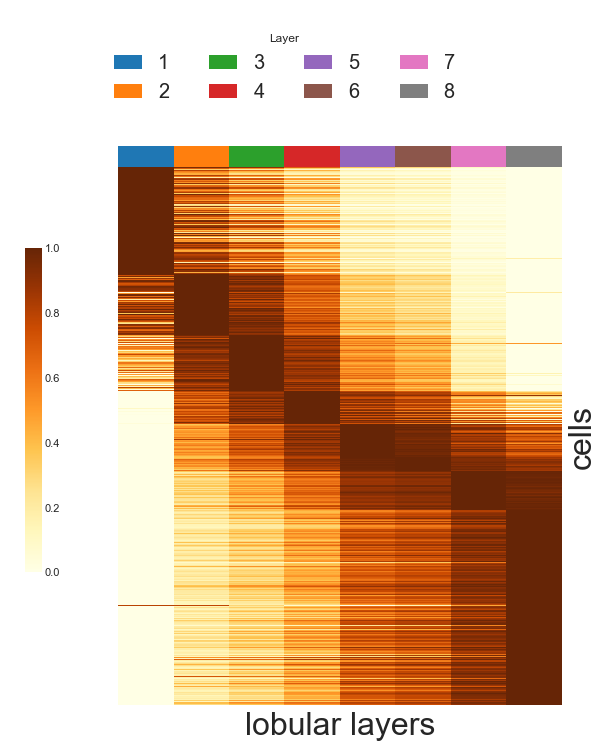

In [28]:
vmax = np.quantile(T, 0.999)
vmax = 1
color_palette = adata_sc.uns["layer_colors"]
cmap = "YlOrBr"
ncol = 4
labels = adata_sc.obs["layer"].cat.categories.astype(str)
df = pd.DataFrame(
    labels, 
    index=labels, 
    columns=["layer"]
)

label_lut = dict(zip(map(str, labels), color_palette))
col_colors = pd.Series(
    df["layer"], 
    index=labels, 
    name="layer").map(label_lut)

g = sns.clustermap(
    T,
    row_cluster=False,
    col_cluster=False,
    standard_scale=False,
    col_colors=col_colors.to_numpy(),
    linewidths=0,
    xticklabels=[],
    yticklabels=[],
    cmap=cmap,
    vmin=0,
    vmax=vmax,
    figsize=(8,10)
)
for label in labels:
    g.ax_col_dendrogram.bar(0, 0, color=label_lut[label], label=label, linewidth=0)

l1 = g.ax_col_dendrogram.legend(
    title="Layer",
    loc="center",
    ncol=ncol,
    fontsize=20,
    title_fontsize='large',
    bbox_to_anchor=(0.5, 0.9),
    bbox_transform=plt.gcf().transFigure,
)

g.cax.set_position([0.05, 0.2, 0.03, 0.45])
ax = g.ax_heatmap
ax.set_xlabel("lobular layers", fontsize=32)
ax.set_ylabel("cells", fontsize=32)
# g.fig.savefig(FIG_DIR + f"spatial_mapping_ot.png", bbox_inches="tight", transparent=True, dpi=DPI)
plt.show()

## SiFT filter

In [29]:
fnames = {}
fnames["Original"] = DATA_DIR + "processed/adata_ot.h5ad"

In [30]:
adatas = {}
adatas["Original"] = sc.read(fnames["Original"])

In [ ]:
fnames = {}
fnames["Original"] = DATA_DIR+"/adata_ot.h5ad"

In [ ]:
adatas = {}
adatas["Original"] = sc.read(fnames["Original"])

### spatial genes (_knn_)

In [31]:
fnames["SiFT (spatial genes; knn)"] = DATA_DIR+"processed/adata_sift_spatial_genes_knn.h5ad"
adatas["SiFT (spatial genes; knn)"] = adatas["Original"].copy()
adatas["SiFT (spatial genes; knn)"].obsm["spatial_genes"] = adatas["SiFT (spatial genes; knn)"][:, l_spatial].X.copy()

In [32]:
sanitize_adata(adatas["SiFT (spatial genes; knn)"])

In [33]:
sft = sift.SiFT(
    adata=adatas["SiFT (spatial genes; knn)"],
    kernel_key="spatial_genes",
    metric="knn",
    n_neighbors=450,
    knn_batch_key="batch",
    copy=False
)

sft.filter(
    embedding_key="X",
    pseudocount=False,
)

sft.filter(
    embedding_key="X_scvi",
    pseudocount=False,
)

sft.filter(
    embedding_key="counts",
    pseudocount=False,
)

INFO     sift: initialized a SiFTer with knn kernel.                                                               
INFO     sift: Filtering cell-cell similarity kernel using projection on `X`.                                      
INFO     sift: The data is `SiFTed`!                                                                               
         The filtered embedding is stored in `adata.X`                                                             
             Finish                                                                                                
INFO     sift: Filtering cell-cell similarity kernel using projection on `X_scvi`.                                 
INFO     sift: The data is `SiFTed`!                                                                               
         The filtered embedding is stored in `adata.obsm['X_scvi_sift']`                                           
             Finish                                                     

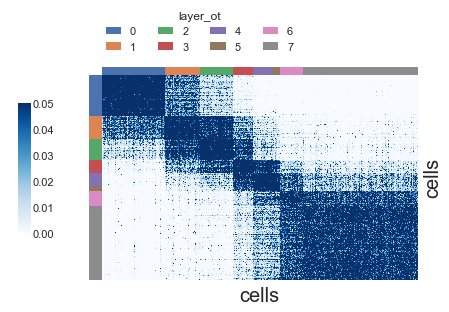

In [34]:
sft.plot_kernel(groupby="layer_ot", ncol=4, vmax=0.05, figsize=(6,4))

In [40]:
process_adata(adatas["SiFT (spatial genes; knn)"], pseudocount=True)

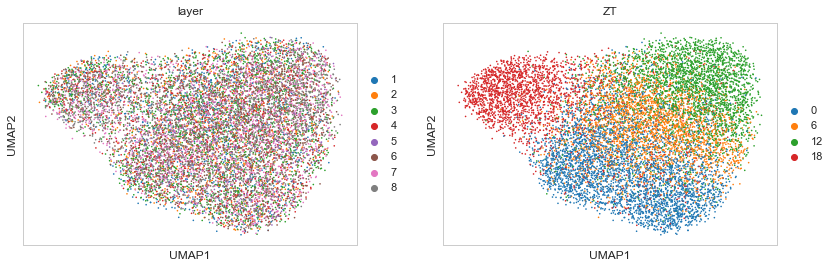

In [41]:
sc.pl.umap(adatas["SiFT (spatial genes; knn)"], color=["layer", "ZT"])

In [ ]:
## Save res
adatas["SiFT (spatial genes; knn)"].write(fnames["SiFT (spatial genes; knn)"])

### OT layers

In [43]:
fnames["SiFT (OT layers)"] = DATA_DIR+"processed/adata_sift_ot_layers.h5ad"
adatas["SiFT (OT layers)"] = adatas["Original"].copy()

In [44]:
sanitize_adata(adatas["SiFT (OT layers)"])

In [45]:
sft = sift.SiFT(
    adata=adatas["SiFT (OT layers)"],
    kernel_key="layer_ot",
    metric="mapping",
    copy=False
)

sft.filter(
    embedding_key="X",
    pseudocount=False,
)

sft.filter(
    embedding_key="X_scvi",
    pseudocount=False,
)

sft.filter(
    embedding_key="counts",
    pseudocount=False,
)

INFO     sift: initialized a SiFTer with mapping kernel.                                                           
INFO     sift: Filtering cell-cell similarity kernel using projection on `X`.                                      
INFO     sift: The data is `SiFTed`!                                                                               
         The filtered embedding is stored in `adata.X`                                                             
             Finish                                                                                                
INFO     sift: Filtering cell-cell similarity kernel using projection on `X_scvi`.                                 
INFO     sift: The data is `SiFTed`!                                                                               
         The filtered embedding is stored in `adata.obsm['X_scvi_sift']`                                           
             Finish                                                     

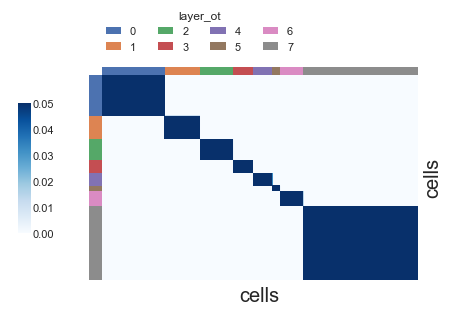

In [46]:
sft.plot_kernel(groupby="layer_ot", ncol=4, vmax=0.05, figsize=(6,4))

In [47]:
process_adata(adatas["SiFT (OT layers)"], use_rep="X_scvi_sift", pseudocount=True)

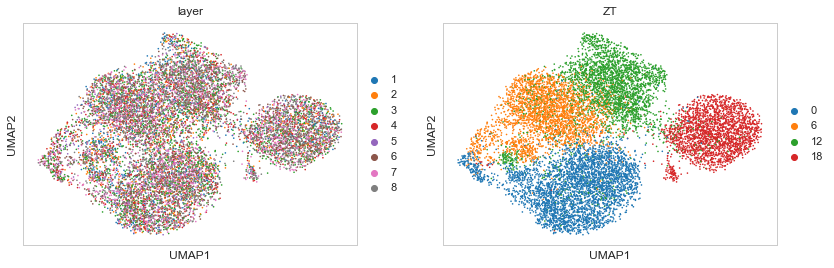

In [48]:
sc.pl.umap(adatas["SiFT (OT layers)"], color=["layer", "ZT"])

In [ ]:
## Save res
adatas["SiFT (OT layers)"].write(fnames["SiFT (OT layers)"])

## Plot res

In [ ]:
adatas = {}

In [ ]:
fnames = {"Original":DATA_DIR+"processed/adata_ot.h5ad",
          "SiFT (spatial genes; knn)":  DATA_DIR+"processed/adata_sift_spatial_genes_knn.h5ad",
          "SiFT (OT layers)":  DATA_DIR+"processed/adata_sift_ot_layers.h5ad",}

In [ ]:
for key, val in fnames.items():
    adatas[key] = sc.read(val)

In [ ]:
l_temporal = ["arntl", "clock", "npas2", "nr1d1", "nr1d2", "per1", "per2", "cry1", "cry2", "dbp", "tef", "hlf", 
               "elovl3", "rora", "rorc"]

In [ ]:
alpha = 0.5
epsilon = 1e-4

In [ ]:
dataset = {"adata_spatial": DATA_DIR + "processed/adata_ZT.h5ad",
           "adata_sc": DATA_DIR+"processed/adata_sift_ot_map.h5ad",
           "sc_key": "X_scvi_sift",
           "reference_names": ref_temporal_genes,
          }

solver = { "rank": None}


training = {}

In [ ]:
solver["epsilon"] = epsilon
solver["alpha"] = alpha

In [ ]:
mapping = get_mapping()
mapping.init_model(solver)
mapping.init_dataset(dataset)
res_, out = mapping.train(training)

In [ ]:
mapping.adata_sc.var["marker"].sum()

In [ ]:
ref_temporal_genes = adatas_spatial["ZT"][:, adatas_spatial["ZT"].var["type"].isin([3])].var_names[np.argsort(
        adatas_spatial["ZT"][:, adatas_spatial["ZT"].var["type"].isin([3])].var["gene_confidence"])][-100:]

# Analyze results

In [49]:
method_colors = {
    "Original": "#7C878E", 
    "SiFT (spatial genes; knn)":  "#5C88DA", 
    "SiFT (OT layers)": "#DAAE5C", 
}

method_label = {
    "Original": "Original data", 
    "SiFT (spatial genes; knn)": "SiFT (zonated genes)",
    "SiFT (OT layers)":  "SiFT (novoSpaRc, zonated)", 
}

method_hatches = {
    "Original": "", 
    "SiFT (spatial genes; knn)": "X",
    "SiFT (OT layers)":  "//", 
}

## Plot `UMAP`s

In [50]:
pal_zt = sns.color_palette("dark", 4)
pal_layers = sns.color_palette("colorblind", 8)

Original


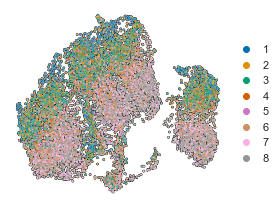

SiFT (spatial genes; knn)


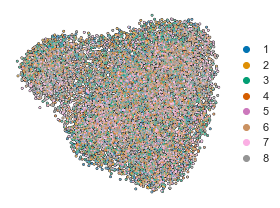

SiFT (OT layers)


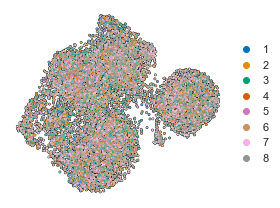

In [52]:
rows = 1
cols = 1
size = 3


for key, adata_ in adatas.items():
    print(key)
    fig, axs = plt.subplots(rows, cols, figsize=(size+1, size))
    sc.pl.umap(adata_, color="layer", 
               add_outline=True, 
               frameon=False, 
               title=key, 
               palette=pal_layers,
               show=False, ax=axs)
    axs.set_title("", fontsize=24)
    plt.tight_layout()
    # plt.savefig(FIG_DIR +f"layers_{key}_leg.png", dpi=300)
    plt.show()

Original


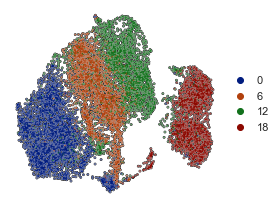

SiFT (spatial genes; knn)


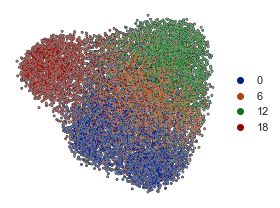

SiFT (OT layers)


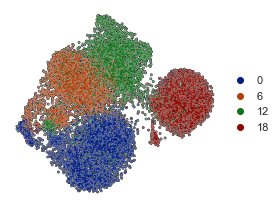

In [54]:
rows = 1
cols = 1
size = 3


for key, adata_ in adatas.items():
    print(key)
    fig, axs = plt.subplots(rows, cols, figsize=(size+1, size))
    sc.pl.umap(adata_, color="ZT", 
               add_outline=True, 
               frameon=False, 
               palette=pal_zt,
               show=False, ax=axs)
    axs.set_title("")
    plt.tight_layout()
    # plt.savefig(FIG_DIR +f"timepoints_{key}.png", dpi=300)
    plt.show()

## Load temporal reconstruction

This code loads the results from running  `run_temporal_map.py`. <br>
`run_temporal_map.py` evaluates the temporal reconstruction of the different settings (`Original`, `SiFT (zonated genes)`, and `SiFT (novoSpaRc, zonated)`) using 0, 5 or 10 marker genes over 10 repetitions.


In [55]:
df_res = pd.DataFrame(columns=["type",
                               "alpha", 
                               "epsilon", 
                               "markers",
                               "num_markers",
                               "pears_mean",
                               "converged",
                               "out",
                               "accuracy",
                              ])

In [59]:
dir_name = OUTPUT_DIR +"res_rng/"
res = []
if os.path.isdir(dir_name):
    for filename in os.listdir(dir_name):
        print(filename)
        fname = os.path.join(dir_name, filename)
        if os.path.isfile(fname):
            res_ = pd.read_pickle(fname)
            res_["rep"] = filename.split("-")[-1]
            res_["type"] = filename.split("-")[0]
            res.append(res_)
df = pd.concat(res)

original_X_scvi-8
sift_ot_layers_X_scvi_sift_psd-0
sift_knn_X_scvi_sift_psd-6
sift_ot_layers_X_scvi_sift_psd-1
original_X_scvi-3
original_X_scvi-5
sift_ot_layers_X_scvi_sift_psd-8
original_X_scvi-2
sift_knn_X_scvi_sift_psd-3
sift_ot_layers_X_scvi_sift_psd-5
sift_knn_X_scvi_sift_psd-2
sift_knn_X_scvi_sift_psd-0
original_X_scvi-4
sift_ot_layers_X_scvi_sift_psd-3
sift_knn_X_scvi_sift_psd-5
original_X_scvi-0
sift_knn_X_scvi_sift_psd-8
sift_ot_layers_X_scvi_sift_psd-6
sift_ot_layers_X_scvi_sift_psd-2
sift_knn_X_scvi_sift_psd-1
original_X_scvi-7
original_X_scvi-9
sift_ot_layers_X_scvi_sift_psd-7
sift_knn_X_scvi_sift_psd-4
sift_knn_X_scvi_sift_psd-7
original_X_scvi-6
sift_ot_layers_X_scvi_sift_psd-4
sift_ot_layers_X_scvi_sift_psd-9
original_X_scvi-1


In [60]:
df = df[df["converged"] == True]

In [62]:
idx_pears = df.groupby(["num_markers", "type", "rep"])["pears_mean"].transform(max) == df["pears_mean"]

In [63]:
df_plt_pears = df[idx_pears]

In [64]:
df_plt_pears["pears_mean"] = df_plt_pears["pears_mean"].astype(float)

In [65]:
mean_ = df_plt_pears.groupby(["num_markers", "type"])["pears_mean"].mean()
std_ = df_plt_pears.groupby(["num_markers", "type"])["pears_mean"].std()

In [66]:
mean_

num_markers  type                          
0            original_X_scvi                   0.355848
             sift_knn_X_scvi_sift_psd          0.441551
             sift_ot_layers_X_scvi_sift_psd    0.711388
5            original_X_scvi                   0.568188
             sift_knn_X_scvi_sift_psd          0.819317
             sift_ot_layers_X_scvi_sift_psd    0.952381
10           original_X_scvi                   0.568003
             sift_knn_X_scvi_sift_psd          0.893573
             sift_ot_layers_X_scvi_sift_psd    0.959057
Name: pears_mean, dtype: float64

In [67]:
std_

num_markers  type                          
0            original_X_scvi                   0.000007
             sift_knn_X_scvi_sift_psd          0.000693
             sift_ot_layers_X_scvi_sift_psd    0.000036
5            original_X_scvi                   0.143032
             sift_knn_X_scvi_sift_psd          0.074522
             sift_ot_layers_X_scvi_sift_psd    0.012678
10           original_X_scvi                   0.126632
             sift_knn_X_scvi_sift_psd          0.034631
             sift_ot_layers_X_scvi_sift_psd    0.008818
Name: pears_mean, dtype: float64

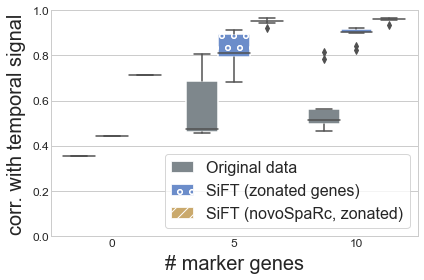

In [68]:
rows = 1
cols = 1
size = 4

fig, axs = plt.subplots(rows, cols, figsize=(size+2, size))
hue_order = [
    "original_X_scvi",
    "sift_knn_X_scvi_sift_psd",
    "sift_ot_layers_X_scvi_sift_psd",
]

plb = sns.boxplot(x="num_markers", 
                  y="pears_mean", 
                  hue="type",
                  data=df_plt_pears,
                  hue_order=hue_order, 
                  palette=list(method_colors.values()),
                  ax=axs)

hatches = ["", "", "o","o", "//",  "//", "", "o", "//", "", "o", "//", "", "o" ,"//",]
alphas = [1,1,1,1,0.5,0.5,1,1,0.5,1,1,0.5,1,1,0.5,1,1,0.5]
num_locations = 4
for i, patch in enumerate(plb.patches):
    patch.set_hatch(hatches[i])
    patch.set_edgecolor("white")
    # patch.set_alpha(alphas[i])
    
axs.set_ylim([0, 1])
axs.set_xlabel("# marker genes", fontsize=20)
axs.set_ylabel("corr. with temporal signal", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

handles, labels = plb.get_legend_handles_labels()
axs.legend(handles, list(method_label.values()),frameon=True, fontsize=16)


plt.tight_layout()
plt.savefig(FIG_DIR + f"temporal_recon_corr.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()

In [ ]:
import gseapy as gp

In [ ]:
enr_res_hvg = {}
for key, adata_ in adatas.items():
    sc.pp.highly_variable_genes(adata_)
    hvgs = adata_.var_names[np.argsort(adata_.var["highly_variable_rank"].values)][:400]
    genedf = sc.get.obs_df(adata_, 
                           keys=list(hvgs)
                          )
    genedf = genedf.rename(str.upper, axis="columns")
    
    enr_res_hvg[f"{key}"] = gseapy.enrichr(gene_list=list(hvgs),
                                           organism="Mouse",
                                           gene_sets=["KEGG_2019_Mouse", "GO_Biological_Process_2021"],
                                           cutoff = 0.5)

    gseapy.barplot(enr_res_hvg[f"{key}"].res2d, title=f"{key}")
    

In [ ]:
for key, adata_ in adatas.items():
    sc.pl.matrixplot(adata_, 
                     l_temporal, 
                     groupby="ZT", 
                     dendrogram=False, 
                     title=key, )
    plt.tight_layout()
    plt.show()
    

In [ ]:
for key, adata_ in adatas.items():
    sc.pl.matrixplot(adata_, 
                     l_spatial, 
                     groupby="layer", 
                     dendrogram=False, 
                     title=key, 
                     layer="X_scale")
    plt.tight_layout()
    plt.show()
    

### rank genes groups

In [ ]:
for key, adata_ in adatas.items():
    sc.tl.rank_genes_groups(adata_, "ZT", key_added = "rank_genes_groups_ZT")
    sc.tl.rank_genes_groups(adata_, "layer", key_added = "rank_genes_groups_layer")

In [ ]:
for key, adata_ in adatas.items():
    sc.pl.rank_genes_groups_heatmap(adata_,
                                    key="rank_genes_groups_ZT", 
                                    dendrogram=False,)

In [ ]:
adata_

In [ ]:
pal_zt = sns.color_palette("dark", 4)
pal_layer = sns.color_palette("colorblind", 8)
genes_pl = ["cyp2f2", "cyp2e1", "elovl3",]

row = 5
col = 3
size = 4
fig, axs = plt.subplots(row, col, figsize=(col*size, row*size))
i = 0
for key, adata_ in adatas.items():
    j = 2
    sc.pl.umap(adata_, color="ZT", 
               add_outline=True, 
               legend_fontsize=12, 
               legend_fontoutline=1,
               frameon=False, 
               title=key,
               palette=pal_zt,
               show=False, ax=axs[0, i])
    sc.pl.umap(adata_, color="layer", 
               add_outline=True, 
               legend_fontsize=12, 
               legend_fontoutline=1,
               frameon=False, 
               palette=pal_layer,
               show=False, ax=axs[1, i])
    for gene in genes_pl:
        sc.pl.umap(adata_, color=gene, 
                   add_outline=True, 
                   legend_fontsize=12, 
                   legend_fontoutline=1,
                   frameon=False, 
#                    palette=pal_layer,
                   show=False, ax=axs[j, i])
        j += 1
        
    i +=1
plt.show()
plt.tight_layout()
    

## Z+R, ZxR genes

In [69]:
i = 0
genedfs = []
for key, adata_ in adatas.items():
    df = sc.get.obs_df(adata_,
                       keys=[*l_temporal, "ZT", "layer"]
                      )
    df["Type"] = key
    genedfs.append(df)
    
    

In [70]:
genedf = pd.concat(genedfs, ignore_index=True)

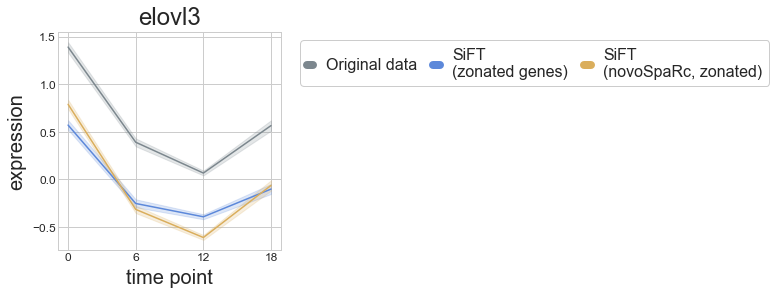

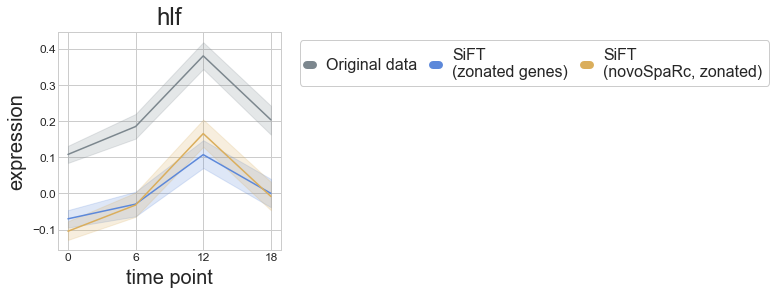

In [77]:
genes = ["elovl3", "hlf"]
rows = 1
cols = 1
size = 4

for i, gene in enumerate(genes):  
    fig, axs = plt.subplots(rows, cols, figsize=(size, size))
    plb = sns.lineplot(data=genedf, 
                       x="ZT", 
                       y=gene, 
                       hue="Type", 
                       hue_order=["Original", "SiFT (spatial genes; knn)", "SiFT (OT layers)", ],
                       palette=list(method_colors.values()),
                       ax=axs)

    axs.set_xlabel("time point", fontsize=20)
    axs.set_ylabel("expression", fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    handles, labels = plb.get_legend_handles_labels()
    leg = axs.legend(handles, ["Original data", "SiFT\n(zonated genes)", "SiFT\n(novoSpaRc, zonated)"], 
               frameon=True,
               fontsize=16, 
               framealpha=1, 
               handleheight=0,
               handlelength=0.4,
               bbox_to_anchor=(1.05, 1.0), loc="upper left", ncol=3, columnspacing=1)
    
    for line in leg.get_lines():
        line.set_linewidth(8.0)
    
    axs.set_title(f"{gene}", fontsize=24)
    plt.tight_layout()
    # plt.savefig(FIG_DIR + f"{gene}_temporal_exp.png", dpi=300, bbox_inches="tight", transparent=True)
    plt.show()
    

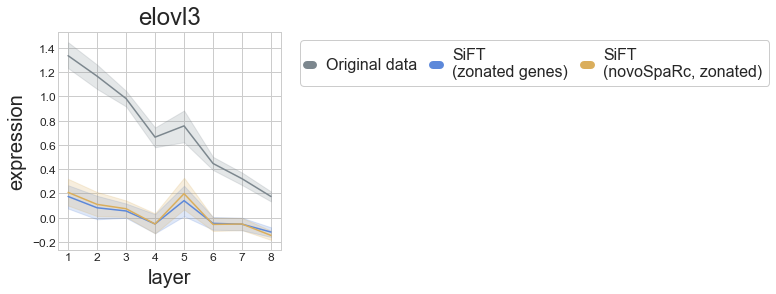

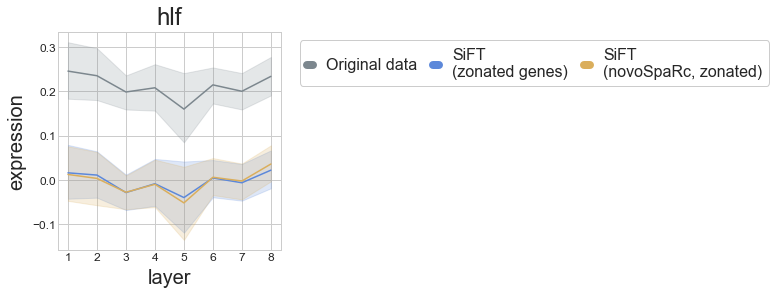

In [74]:
genes =  ["elovl3", "hlf"]
rows = 1
cols = 1
size = 4

for i, gene in enumerate(genes):  
    fig, axs = plt.subplots(rows, cols, figsize=(size, size))
    plb = sns.lineplot(data=genedf, 
                       x="layer", 
                       y=gene, 
                       hue="Type", 
                       hue_order=["Original", "SiFT (spatial genes; knn)", "SiFT (OT layers)"],
                       palette=list(method_colors.values()),
                       ax=axs)

    axs.set_xlabel("layer", fontsize=20)
    axs.set_ylabel("expression", fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    handles, labels = plb.get_legend_handles_labels()
    leg = axs.legend(handles, ["Original data", "SiFT\n(zonated genes)", "SiFT\n(novoSpaRc, zonated)"], 
               frameon=True,
               fontsize=16, 
               framealpha=1, 
               handleheight=0,
               handlelength=0.4,
               bbox_to_anchor=(1.05, 1.0), loc="upper left", ncol=3, columnspacing=1)
    for line in leg.get_lines():
        line.set_linewidth(8.0)
    
    axs.set_title(f"{gene}", fontsize=24)
    # plt.savefig(FIG_DIR + f"{gene}_spatial_exp_leg.png", dpi=300, bbox_inches="tight", transparent=True)
    plt.tight_layout()
    plt.show()
    